# 1. Import Libraries and Dataset

In [18]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

In [19]:
# Importing dataset
zdt = pd.read_csv('/content/ZDT1_10var100gen.csv')
rank_info = pd.read_csv('/content/rank_info.csv')
del zdt['RANK']

In [20]:
# Assign the rank information to the 'Rank' column of the main dataframe
# We assume that the rank data is in the first column of the rank_info dataframe
zdt['Rank'] = rank_info.iloc[:, 0]

# Save the updated dataframe to a new CSV file
updated_csv_path = r'/content/ZDT1_10var100gen_updated.csv'
zdt.to_csv(updated_csv_path, index=False)


In [21]:
# Importing dataset with the rank information
df = pd.read_csv('/content/ZDT1_10var100gen_updated.csv')

In [22]:
df.head()

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,f1,f2,gen,Rank
0,0,0.417022,0.720324,0.000114,0.302333,0.146756,0.092339,0.186260,0.345561,0.396767,0.538817,0.417022,2.482199,1,53.0
1,1,0.019367,0.678836,0.211628,0.265547,0.491573,0.053363,0.574118,0.146729,0.589306,0.699758,0.019367,4.408805,1,52.0
2,2,0.019880,0.026211,0.028306,0.246211,0.860028,0.538831,0.552822,0.842031,0.124173,0.279184,0.019880,4.198771,1,39.0
3,3,0.556240,0.136455,0.059918,0.121343,0.044552,0.107494,0.225709,0.712989,0.559717,0.012556,0.556240,1.693099,1,62.0
4,4,0.000402,0.976759,0.376580,0.973784,0.604716,0.828846,0.574712,0.628076,0.285576,0.586833,0.000402,6.783459,1,47.0


* The dataset contains 10 x variables (x1 - x10) and 2 objective functions (f1, f2) derived from these 10 x variables.
* The 'gen' column represents the generation of data, ranging from 1 to 100. 'Gen 1' signifies the first generation, while 'gen 100' represents the hundredth generation.
* The 'Rank' column represents the rank of the data as defined by the Pareto rule, starting from the 0th rank.
* Each generation generates 100 data rows, thus the dataset comprises 100 * 100 = 10,000 rows.

----------------

# 2. Exploratory Data Analysis

## 2.1. Check the Frequency by Rank and Generation

<ipython-input-23-65a05632f21e>:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal', ticks=np.arange(0, max_gen + 1, 10),


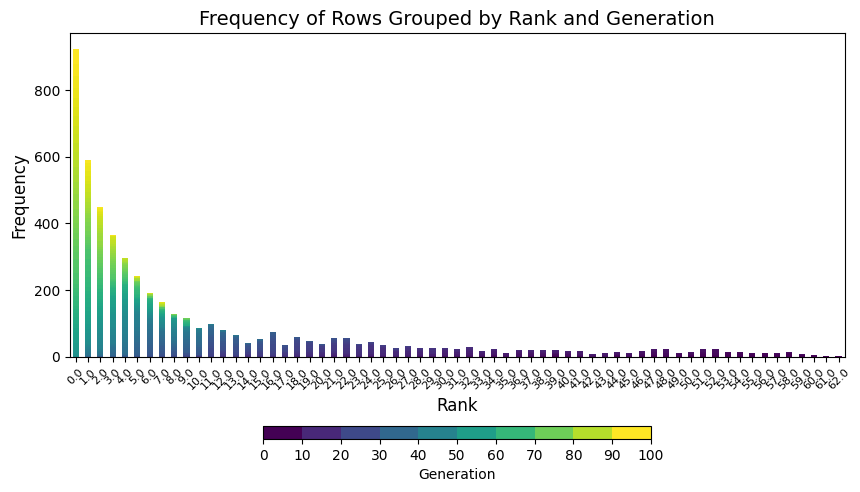

In [23]:
# Grouping by 'Rank' and 'gen' and creating a color palette based on 'gen' values
grouped_data = df.groupby(['Rank', 'gen']).size().unstack().fillna(0)

# Creating a color map based on the maximum 'gen' value
max_gen = df['gen'].max()
colors = plt.cm.viridis(np.linspace(0, 1, max_gen))

# Plotting the stacked bar chart with the custom color map
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency of Rows Grouped by Rank and Generation', fontsize=14)
plt.xticks(rotation=45, fontsize=8)

# Disable the legend
ax.legend().remove()

# Creating a custom legend with a horizontal gradient strip


cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(0, max_gen + 10, 10), cmap.N)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# Adding the colorbar as a legend
cbar = plt.colorbar(sm, orientation='horizontal', ticks=np.arange(0, max_gen + 1, 10),
                    aspect=30, shrink=0.5, pad=0.15)
cbar.set_label('Generation')

plt.show()

* As the generation of data creation increases, the rank tends to decrease (i.e., it gets closer to 0). In the graph above, the initial generations (purple) are mostly distributed after the 20th rank, while the later generations (yellow) are distributed from the 0th to the 9th rank.

## 2.2. Scatter Plot of f1 vs f2

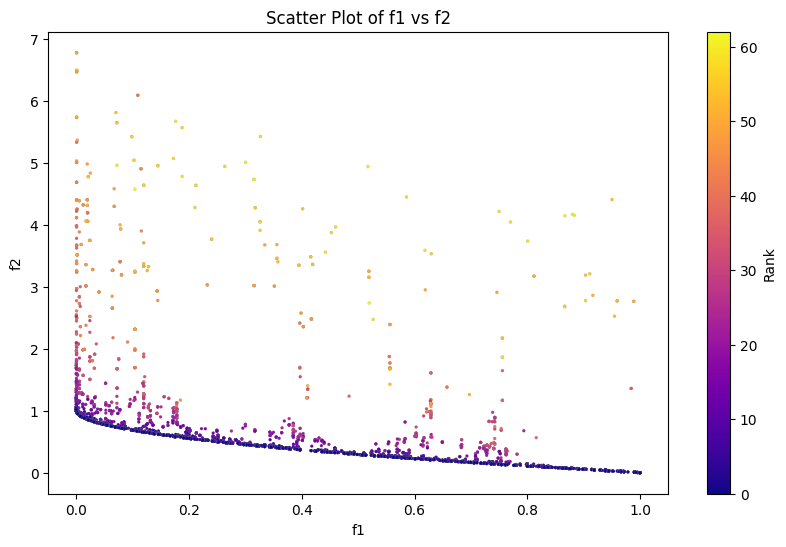

In [24]:
# Creating a scatter plot with a different colormap and circle-shaped dots

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['f1'], df['f2'], c=df['Rank'], cmap='plasma', marker='o',s=5, linewidths=0.1, edgecolor='gray')
plt.xlabel('f1')
plt.ylabel('f2')
plt.title('Scatter Plot of f1 vs f2')
plt.colorbar(scatter, label='Rank')
plt.show()


* The graph above represents a scatter plot for two objective functions, f1 and f2. The prominent purple dots at the forefront of the graph represent high-ranked (rank 0) data, which constitute the desired Pareto set. However, distinguishing the Pareto set, indicated by these purple dots, from nearby lower-ranked data is challenging due to their close proximity.

---------------------

# 3. Data Preprocessing

This data preprocessing, which is designed to classify the 'y' variable for subsequent work in predicting the Pareto set, involves three categories:
* Multi-class with ten y classes (ranks 0-9),
* Three-class with three y classes
(lower, middle, high ranks from 0-62), and
* Binary class with two y classes
(lower and high ranks from 0-62).

## 3.1. Multi-class with ten y classes (ranks 0-9)



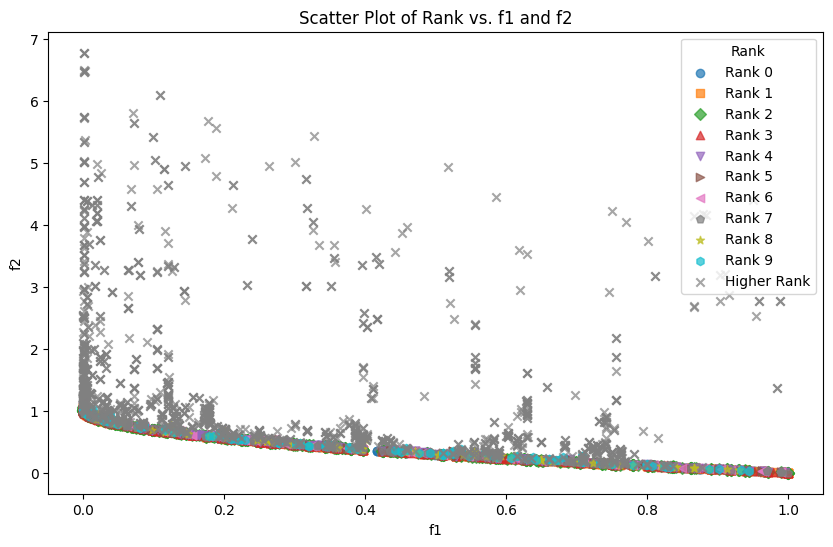

In [26]:

# Define colors and marker styles for each rank (including null)

# 'o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h'

markers = {
    0: 'o',
    1: 's',
    2: 'D',
    3: '^',
    4: 'v',
    5: '>',
    6: '<',
    7: 'p',
    8: '*',
    9: 'h',
    None: 'x'  # Marker style for null values
}

# Create a scatter plot with different marker styles for each rank
plt.figure(figsize=(10, 6))

# Plot data points with ranks
for rank, marker in markers.items():
    if rank is not None:
        subset = df[df['Rank'] == rank]
        plt.scatter(subset['f1'], subset['f2'], label=f'Rank {rank}', marker=marker, alpha=0.7)

# Plot data points with no rank separately
subset_no_rank = df[df['Rank'] > 9]
plt.scatter(subset_no_rank['f1'], subset_no_rank['f2'], label='Higher Rank', marker='x', c='gray', alpha=0.7)

# Set labels and legend
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend(title='Rank')
plt.title('Scatter Plot of Rank vs. f1 and f2')

# Show the plot
plt.show()


* Our initial approach was to classify the y variable into ranks from 0 to 9 and exclude ranks above 10 (rank 10 and higher) from the analysis. However, as shown in the graph, the data within the lower ranks (0-9) are very closely clustered, making it a challenge to develop an algorithm to predict each rank. Additionally, excluding data of rank 10 and above significantly reduces the amount of data available for use, making it difficult to build an accurate model.

------------------

## 3.2. Three-class with three y classes
* Lower, middle, high ranks from 0-62.

## 3.2.1. Classify and visualize the classes


In [ ]:
margin_1 = 1
margin_2 = 10

df['v1_class'] = df['Rank'].apply(lambda x: 1 if x <= margin_1 else (2 if x <= margin_2 else 3))

In [ ]:
# Grouping by 'v1_class' and counting frequencies
df.groupby('v1_class')['Rank'].agg(['min', 'max','count'])

,min,max,count
v1_class,,,
1,0,1,1515
2,2,10,2038
3,11,62,1447


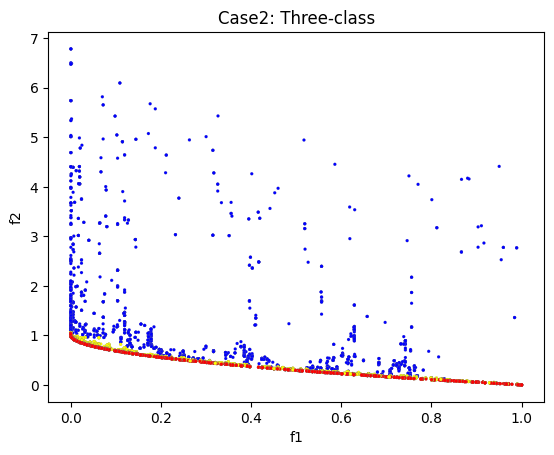

In [ ]:
# Define colors for different v1_class values
colors = {1: 'red', 2: 'yellow', 3: 'blue'}

# Adjusting the scatter plot to have circle-shaped dots with gray boundary lines
plt.scatter(df['f1'], df['f2'], c=df['v1_class'].map(colors), edgecolor='gray', marker='o', s=5, linewidths=0.1)

plt.xlabel('f1')
plt.ylabel('f2')
plt.title('Case2: Three-class')
plt.show()

* In our improved second approach, we have adopted a method of dividing the y variable into three categories: low rank, medium rank, and high rank. This classification method encompasses the entire range of our data, including all ranks from 0 to 62. Such an approach helps prevent accuracy degradation that can occur due to insufficient data. The rank criteria defining each category can be adjusted through 'margin_1' and 'margin_2' values. According to the current settings, low rank is defined as 0 and 1, medium rank as 2 to 10, and high rank as 11 and above, with the number of data points in each category being 1515, 2038, and 1447 respectively, which is a well-balanced distribution. In the presented graph, each category is visually distinguished by color: red for low rank, yellow for medium rank, and blue for high rank.

## 3.2.2 Apply Desicion Tree

In [ ]:
# Prepare the feature variables (X) and the target variable (y) after dropping NaN values
X_clean = df.loc[:, 'x1':'x10']  # Selecting columns x1 to x10 for features
y_clean = df['v1_class']

In [ ]:
# Splitting the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, stratify=y_clean, random_state=42
)

In [ ]:
# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

In [ ]:
# Train the classifier
dt_classifier.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [ ]:
# Predictions
y_pred = dt_classifier.predict(X_test)

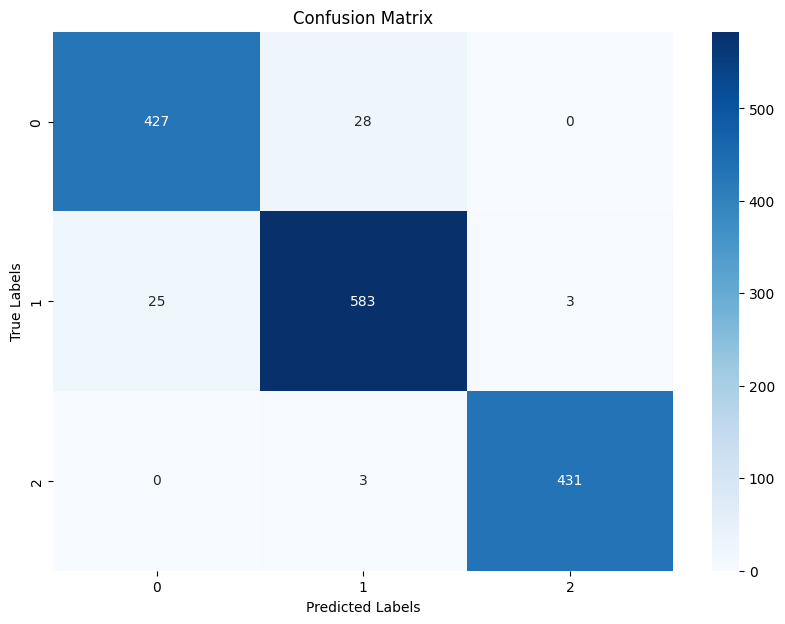

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

*
Based on the previously defined y variable, we implemented a decision tree algorithm using independent variables from x1 to x10. The implementation process involved four main steps:
1. Creation of training and testing datasets,
2. Application of the decision tree classifier,
3. Testing of the algorithm, and
4. Analysis of accuracy.

* In creating the training and testing datasets, we ensured balanced sampling across each y group.
* As indicated by the confusion matrix, the application of the decision tree resulted in high accuracy rate, recall rate, and F1 score. However, there were about 20 instances of misclassification observed in the lower and middle ranks.

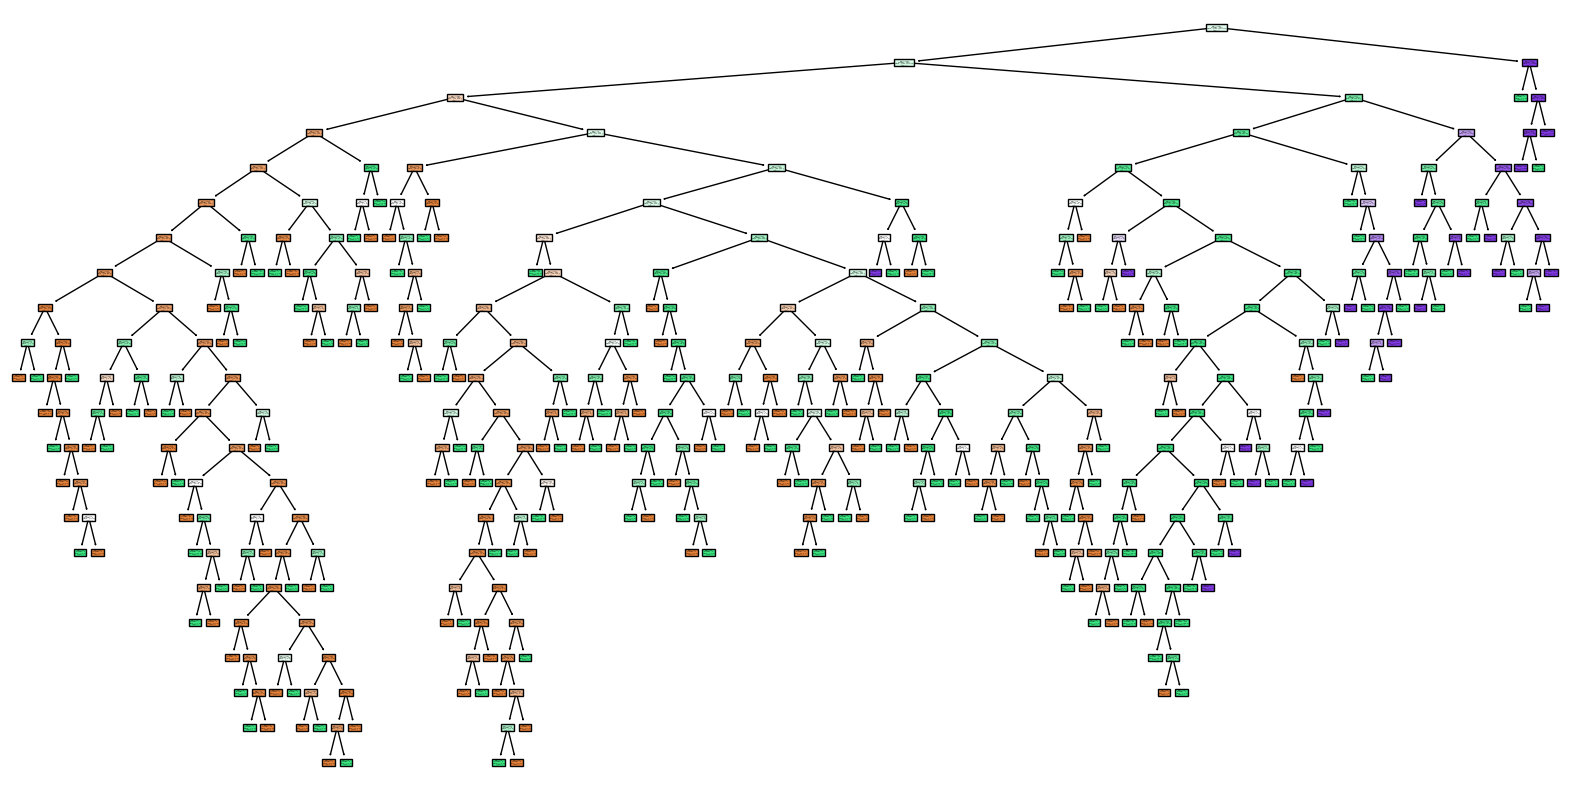

In [ ]:
# Plotting the decision tree

plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, filled=True, feature_names=X_clean.columns, class_names=["1", "2", "3"])
plt.show()

* The graph above displays a visualized decision tree algorithm. Due to the tree's deep depth and numerous nodes, interpreting the algorithm from the graph is quite challenging. In an attempt to create a more interpretable graph, we experimented with limiting the depth of the tree. However, this adjustment significantly reduced the accuracy of the algorithm.



---


## 3.3. Binary class with two y classes
* Low and high ranks from 0-62.

## 3.3.1. Classify and visualize the classes


In [ ]:
margin_1 = 1
margin_2 = 10

df['v2_class'] = df['Rank'].apply(lambda x: float('nan') if x <= margin_1 else (2 if x <= margin_2 else 3))

In [ ]:
# Filtering the DataFrame for v2_class values (remove nan values)
filtered_df = df[(df['v2_class'] == 2) | (df['v2_class'] == 3)]

In [ ]:
# Grouping by 'v2_class' and counting frequencies
filtered_df.groupby('v2_class')['Rank'].agg(['min', 'max','count'])

,min,max,count
v2_class,,,
2.0,2,10,2038
3.0,11,62,1447


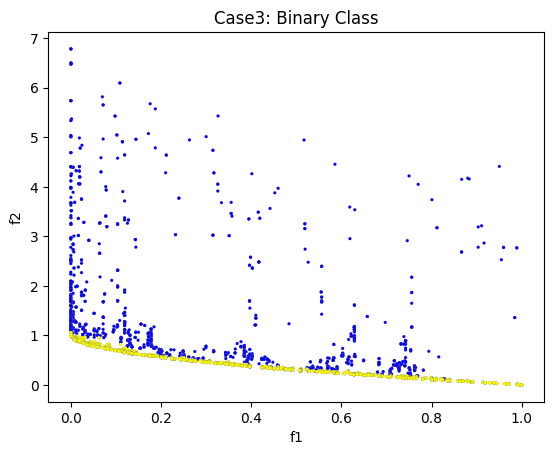

In [ ]:
# Define colors for different v1_class values
colors = {1: 'red', 2: 'yellow', 3: 'blue'}

# Adjusting the scatter plot to include only v1_class values 1 and 2
plt.scatter(filtered_df['f1'], filtered_df['f2'], c=filtered_df['v2_class'].map(colors), edgecolor='gray', marker='o', s=5, linewidths=0.1)

plt.xlabel('f1')
plt.ylabel('f2')
plt.title('Case3: Binary Class')
plt.show()

*
Our next method involves creating binary classes for the y variable. As seen in the graph above, the yellow dots represent the low rank, while the blue dots indicate the high rank. Similarly, the boundary between the groups can be adjusted through the margin.

## 3.3.2. Apply Decision Tree Algorithm

In [ ]:
# Prepare the feature variables (X) and the target variable (y) after dropping NaN values
X_clean = filtered_df.loc[:, 'x1':'x10']  # Selecting columns x1 to x10 for features
y_clean = filtered_df['v2_class']

In [ ]:
# Splitting the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, stratify=y_clean, random_state=42
)

In [ ]:
# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

In [ ]:
# Train the classifier
dt_classifier.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [ ]:
# Predictions
y_pred = dt_classifier.predict(X_test)

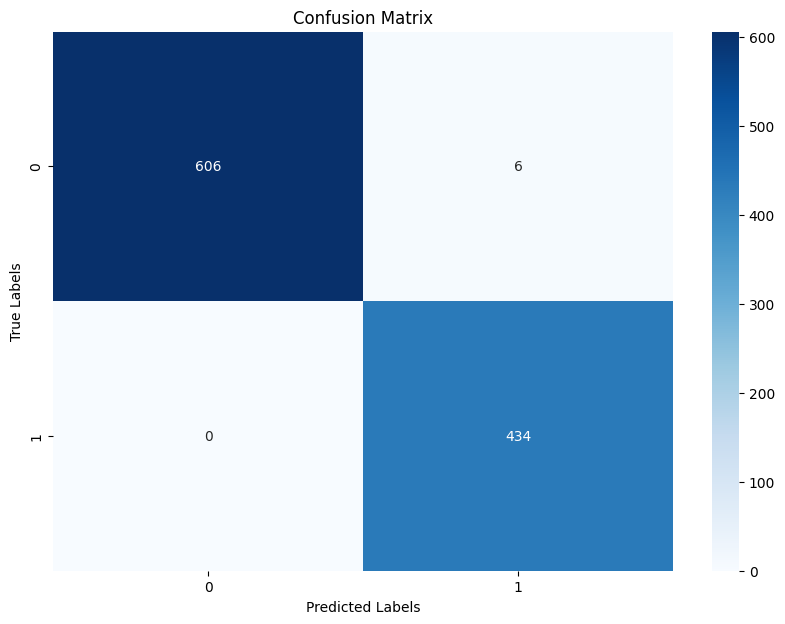

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

*
After applying the decision tree algorithm to the binary classes, we analyzed its accuracy and found the results to be excellent. Apart from six data points, all others were accurately classified.

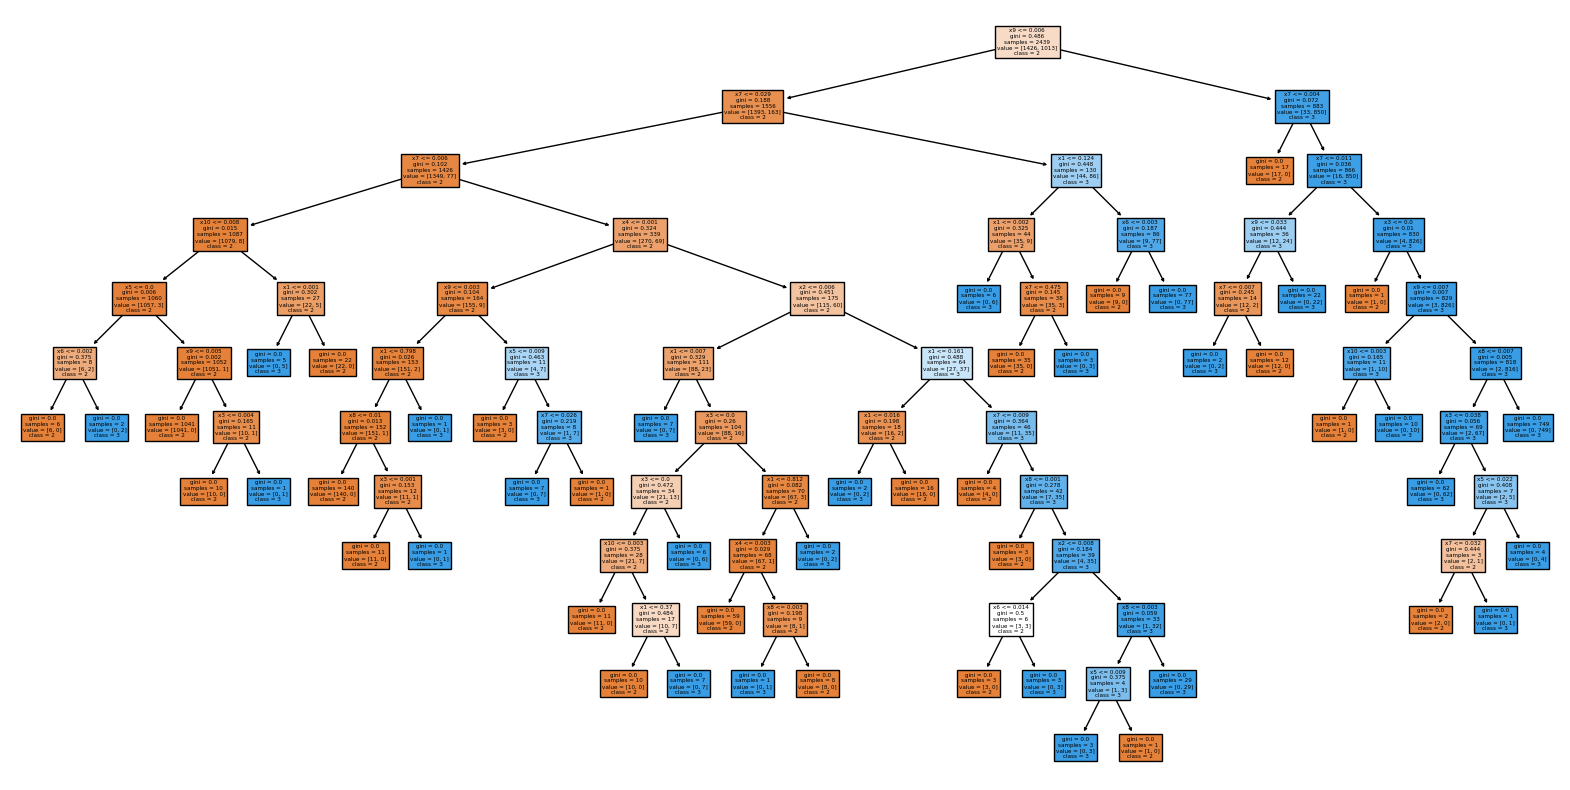

In [ ]:
# Plotting the decision tree


plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, filled=True, feature_names=X_clean.columns, class_names=["2", "3"])
plt.show()

* Compared to when we divided y into three classes, the decision tree plot appears easier to interpret when y is categorized into binary classes.

## 3.3.3. Adjust the margin

*
We have confirmed that the decision tree works very well. Now, we will observe the accuracy of the algorithm while adjusting the margin between the two y groups and determine the optimal margin.
*
The graph below displays precision, recall, and accuracy. The x-axis, labeled 'r1_cap', represents the upper limit of the low rank group. For instance, if 'r1_cap' is 0, the low rank group consists only of data with rank 0. If 'r1_cap' is 1, it includes data with ranks 0 and 1, and if 'r1_cap' is 2, it includes data with ranks 0, 1, and 2. Considering our total of 62 ranks, 'r1_cap' is defined up to 50. Additionally, each graph contains five lines representing five different scenarios based on the 'gap'. The 'gap' refers to the margin between the low and high rank groups. For example, if 'r1_cap' is 3, the low rank group includes data with ranks 0 to 3. If the 'gap' is 5, the high rank group starts from rank 8 (3 + 5 gap), and if the 'gap' is 10, it starts from rank 13 (3 + 10 gap). We set the 'gap' values to 5, 10, 15, 20, and 30 to observe how the decision tree performs across the entire range of ranks.

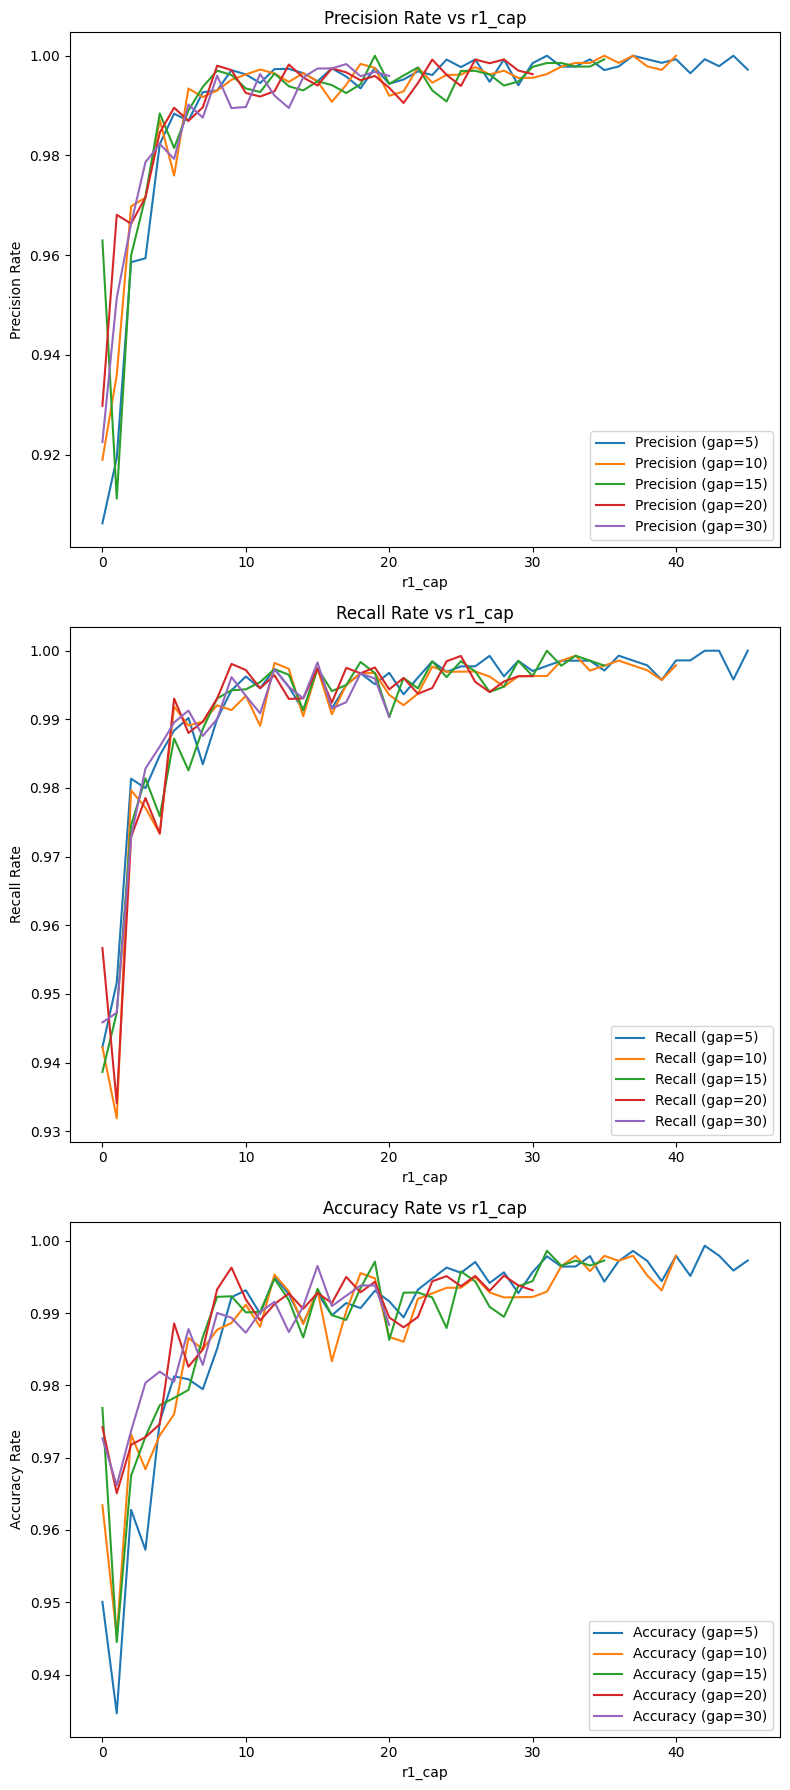

In [ ]:
# Define the gap list
gap_list = [5, 10, 15, 20, 30]
eval_results = {gap: [] for gap in gap_list}

# Loop over each gap value
for gap in gap_list:
    r1_min = df['Rank'].min()
    r1_max = 50 - gap

    # Loop over r1_cap
    for r1_cap in range(r1_min, r1_max + 1):
        # Create v3_class
        df['v3_class'] = np.where(df['Rank'] <= r1_cap, 1, np.where(df['Rank'] <= r1_cap + gap, 2, np.nan))

        # Drop rows with nan in v3_class
        df_clean = df.dropna(subset=['v3_class'])

        # Prepare the feature variables (X) and the target variable (y)
        X = df_clean.loc[:, 'x1':'x10']
        y = df_clean['v3_class']

        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

        # Initialize and train the Decision Tree Classifier
        classifier = DecisionTreeClassifier(random_state=42)
        classifier.fit(X_train, y_train)

        # Predictions and evaluations
        y_pred = classifier.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        # Store the results
        eval_results[gap].append((r1_cap, precision, recall, accuracy))

# Creating subplots for Precision, Recall, and Accuracy, placed vertically
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Plotting results for each gap
for gap in gap_list:
    results_df = pd.DataFrame(eval_results[gap], columns=['r1_cap', 'Precision', 'Recall', 'Accuracy'])

    # Precision Plot
    axs[0].plot(results_df['r1_cap'], results_df['Precision'], label=f'Precision (gap={gap})')
    axs[0].set_xlabel('r1_cap')
    axs[0].set_ylabel('Precision Rate')
    axs[0].set_title('Precision Rate vs r1_cap')
    axs[0].legend()

    # Recall Plot
    axs[1].plot(results_df['r1_cap'], results_df['Recall'], label=f'Recall (gap={gap})')
    axs[1].set_xlabel('r1_cap')
    axs[1].set_ylabel('Recall Rate')
    axs[1].set_title('Recall Rate vs r1_cap')
    axs[1].legend()

    # Accuracy Plot
    axs[2].plot(results_df['r1_cap'], results_df['Accuracy'], label=f'Accuracy (gap={gap})')
    axs[2].set_xlabel('r1_cap')
    axs[2].set_ylabel('Accuracy Rate')
    axs[2].set_title('Accuracy Rate vs r1_cap')
    axs[2].legend()

plt.tight_layout()
plt.show()


*
When examining the graphs for precision, recall, and accuracy, we notice that the values stabilize when the upper limit of the low rank group surpasses around 10. The effectiveness of different 'gap' values varies depending on whether we focus on precision, recall, or accuracy. At this phase, we can draw the following conclusion: the predictive accuracy of the algorithm increases when the y variable is categorized into binary classes.

* In the next phase, we will explore various algorithms beyond the decision tree, adjusting the gap between the two y groups (both with and without the gap approach). This will help us in finding a model that accurately predicts the pareto and non-pareto sets.